In [ ]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
import random

np.set_printoptions(threshold=sys.maxsize)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Resizing images
SIZE_X = 640
SIZE_Y = 640
n_classes= 10 # Number of classes for segmentation

TRAIN_PATH_X = '/content/gdrive/My Drive/ISD/OCT/8 layer train/images'
TRAIN_PATH_Y = '/content/gdrive/My Drive/ISD/OCT/8 layer train/layers'

train_ids_x = next(os.walk(TRAIN_PATH_X))[2]
train_ids_y = next(os.walk(TRAIN_PATH_Y))[2]

In [ ]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob(TRAIN_PATH_X):
    for img_path in glob.glob(os.path.join(directory_path, "*.bmp")):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

#Convert list to array for machine learning processing
train_images = np.array(train_images)

In [ ]:
#Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob(TRAIN_PATH_Y):
    for mask_path in glob.glob(os.path.join(directory_path, "*.bmp")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

#Convert list to array for machine learning processing
train_masks = np.array(train_masks)

In [ ]:
#Encode labels
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further spliting the training data to a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

Class values in the dataset are ...  [0 1 2 3 4 5 6 7 8]


In [ ]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout


################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=SIZE_Y, IMG_WIDTH=SIZE_X, IMG_CHANNELS=1)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 640, 640, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 640, 640, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
#running a trained model
model_path = '8layer250epoch.hdf5'

history = model.load_weights(model_path)

_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

1/1 [==============================] - 2s 2s/step - loss: 0.1921 - accuracy: 0.9468
Accuracy is =  94.68310475349426 %


In [ ]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 20,
                    verbose=1,
                    epochs=250,
                    validation_data=(X_test, y_test_cat),
                    #class_weight=class_weights,
                    shuffle=False)


_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

Epoch 1/250
1/1 [==============================] - 38s 38s/step - loss: 0.3292 - accuracy: 0.8787 - val_loss: 0.4563 - val_accuracy: 0.8540
Epoch 2/250
1/1 [==============================] - 34s 34s/step - loss: 0.3203 - accuracy: 0.8821 - val_loss: 0.4403 - val_accuracy: 0.8575
Epoch 3/250
1/1 [==============================] - 36s 36s/step - loss: 0.3149 - accuracy: 0.8817 - val_loss: 0.4474 - val_accuracy: 0.8529
Epoch 4/250
1/1 [==============================] - 32s 32s/step - loss: 0.3096 - accuracy: 0.8824 - val_loss: 0.4357 - val_accuracy: 0.8645
Epoch 5/250
1/1 [==============================] - 33s 33s/step - loss: 0.3015 - accuracy: 0.8889 - val_loss: 0.4207 - val_accuracy: 0.8735
Epoch 6/250
1/1 [==============================] - 32s 32s/step - loss: 0.2942 - accuracy: 0.8966 - val_loss: 0.4310 - val_accuracy: 0.8717
Epoch 7/250
1/1 [==============================] - 32s 32s/step - loss: 0.2857 - accuracy: 0.9005 - val_loss: 0.3861 - val_accuracy: 0.8836
Epoch 8/250
1/1 [===

In [ ]:
model.save('8layer200epoch2.hdf5') #saving model

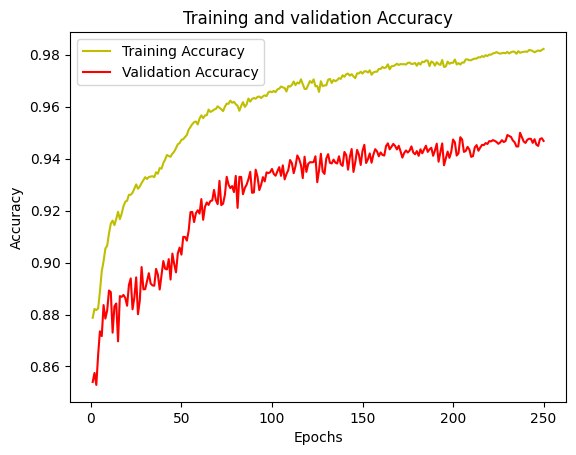

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 [==============================] - 1s 1s/step


In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7952636


IoU for class1 is:  0.9970875
IoU for class2 is:  0.98063976
IoU for class3 is:  0.9645546
IoU for class4 is:  0.9828816


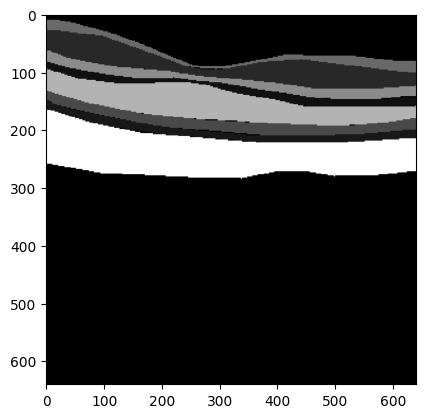

In [ ]:
## This is example of IOU of 4 class, if you need provide corresponding amount of class

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

1/1 [==============================] - 1s 1s/step


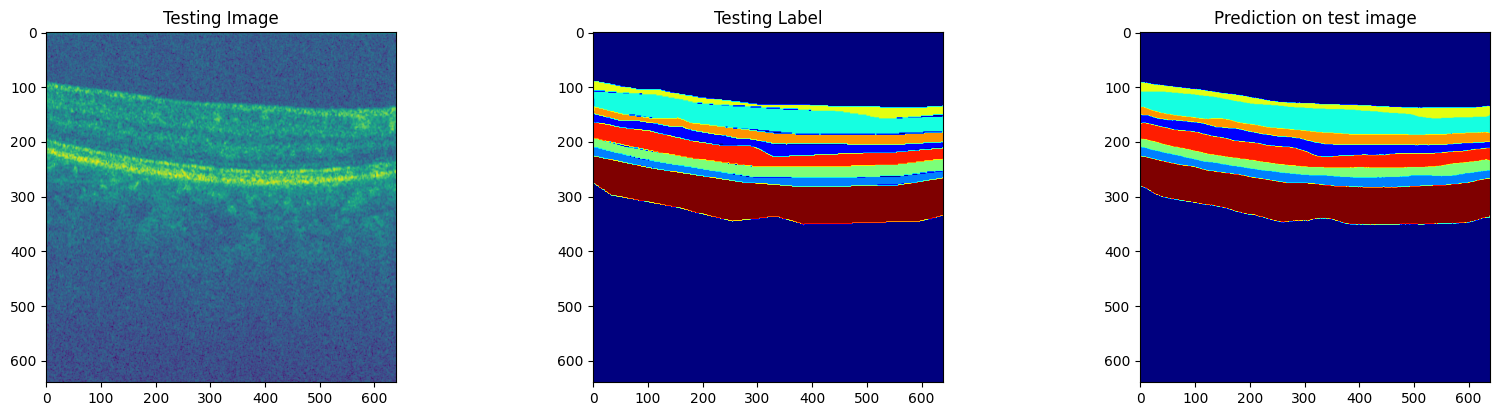

In [ ]:
test_img_number = 5
test_img = X_train[test_img_number]
ground_truth= y_train[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
#Capture training image info as a list
test_test = []

test_path = "/content/gdrive/My Drive/ISD/OCT/8 layer train/test pics"

for directory_path in glob.glob(test_path):
    for img_path in glob.glob(os.path.join(directory_path, "*.bmp")):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        test_test.append(img)
        print(img_path)

#Convert list to array for machine learning processing
test_test = np.array(test_test)

test_test = np.expand_dims(test_test, axis=3)
test_test = normalize(test_test, axis=1)

/content/gdrive/My Drive/ISD/OCT/8 layer train/test pics/177.bmp
/content/gdrive/My Drive/ISD/OCT/8 layer train/test pics/277.bmp
/content/gdrive/My Drive/ISD/OCT/8 layer train/test pics/377.bmp


1/1 [==============================] - 2s 2s/step


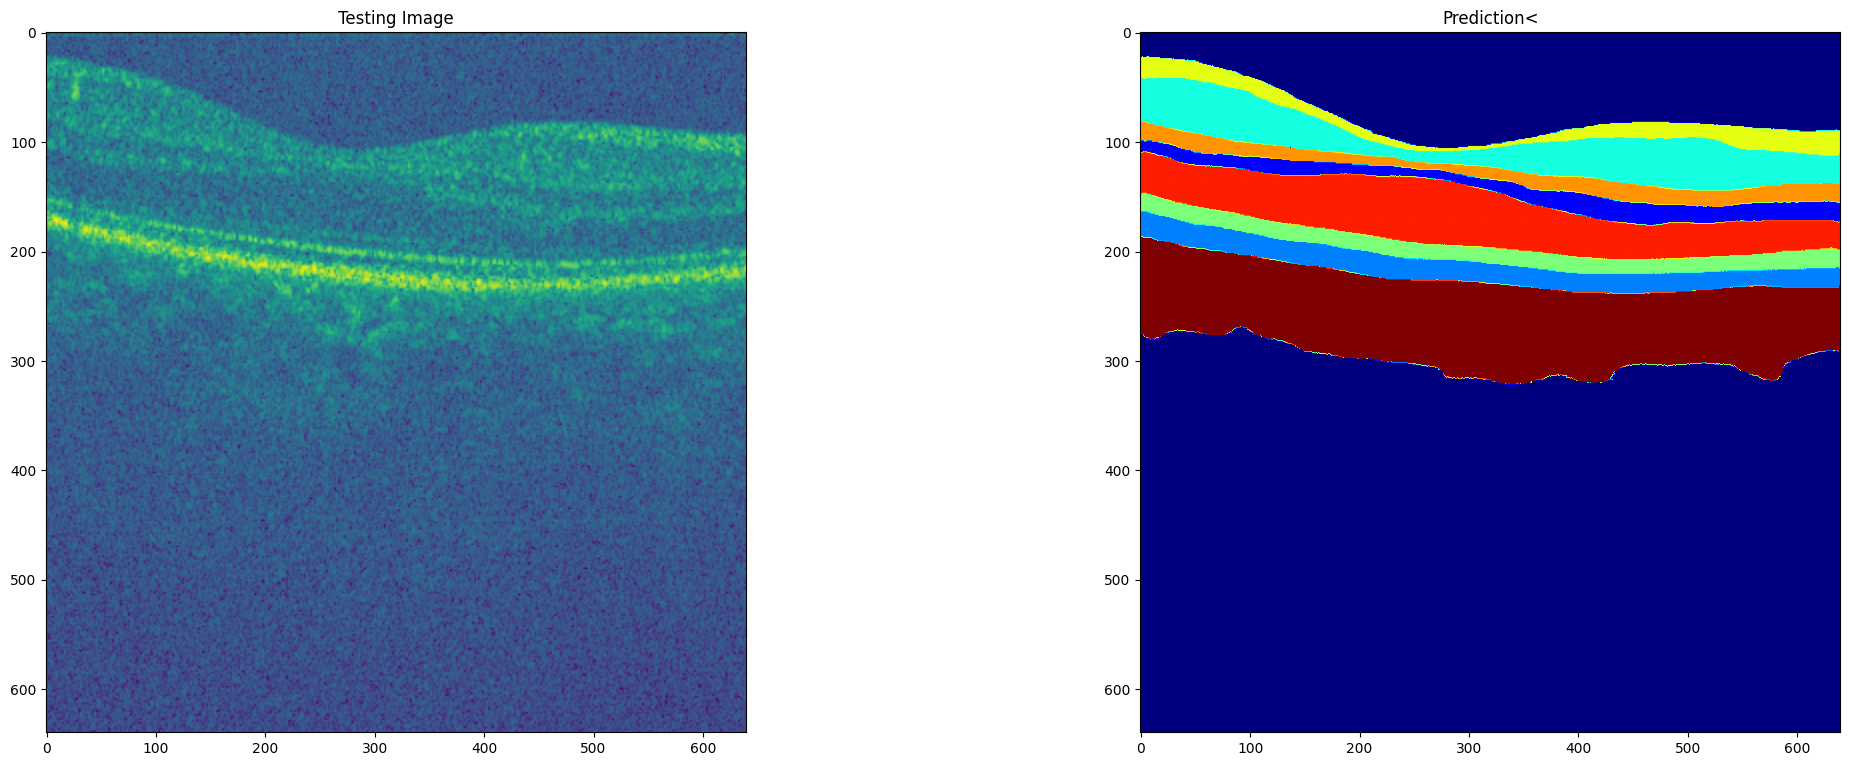

In [ ]:
test1 = test_test[0]
test_img_norm=test1[:,:,0][:,:,None]
test=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(40, 20))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test1[:,:,0])

plt.subplot(232)
plt.title('Prediction<')
# plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.imshow(predicted_img, cmap='jet')

In [ ]:
from matplotlib import image as mpimg
mpimg.imsave('predicted_177.bmp', predicted_img, cmap='jet')

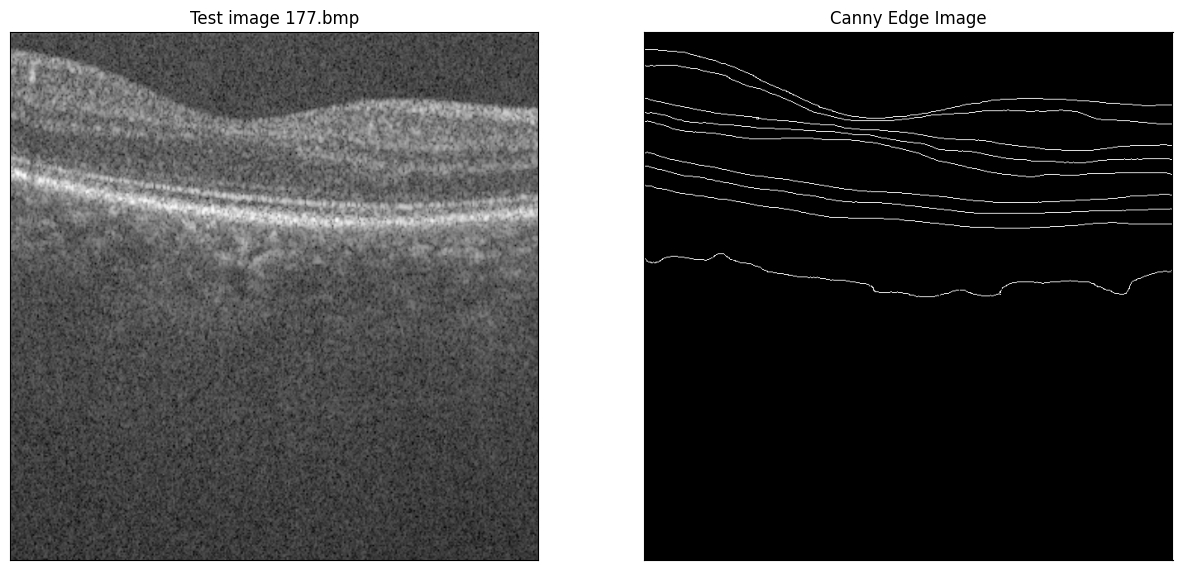

In [ ]:
#img3 = cv2.imread('layers180.bmp')
img3 = test1

input = cv2.imread('predicted_177.bmp')

gray_image = cv2.cvtColor(input, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray_image,55,55)

figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img3, cmap='gray')
plt.title('Test image 177.bmp'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

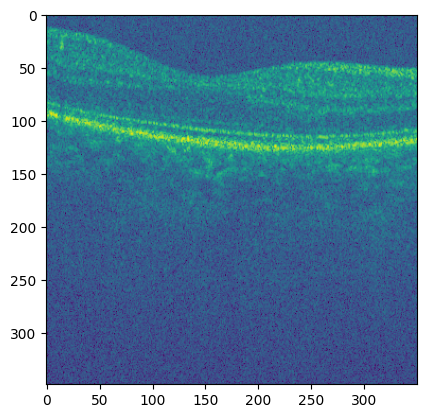

In [ ]:
img5 = plt.imread('177.bmp')
plt.imshow(img5)

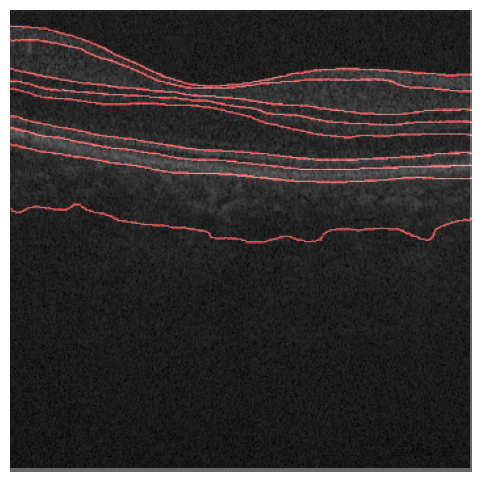

In [ ]:
image2 = edges
image1 = plt.imread('177.bmp')

scale_factor = 0.55

# Resize image
resized_image = cv2.resize(image2, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

# Create a mask for the edges
_, binary_edges = cv2.threshold(resized_image, 0, 255, cv2.THRESH_BINARY)

# Convert the edges to red
overlay_image = cv2.merge([binary_edges, resized_image, resized_image])

# Create a figure and plot the first image
plt.figure(figsize=(8, 6))
plt.imshow(image1, cmap='gray')

# Overlay the second image with transparency
alpha = 0.6  # Adjust transparency
plt.imshow(overlay_image, cmap='gray', alpha=alpha)
plt.axis('off')
plt.show()